In [18]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ruizgara_socofing_path = kagglehub.dataset_download('ruizgara/socofing')

print('Data source import complete.')


Data source import complete.


In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/socofing/socofing/SOCOFing/Altered/Altered-Hard/282__M_Left_little_finger_Zcut.BMP
/kaggle/input/socofing/socofing/SOCOFing/Altered/Altered-Hard/424__M_Right_middle_finger_Zcut.BMP
/kaggle/input/socofing/socofing/SOCOFing/Altered/Altered-Hard/87__M_Right_index_finger_Obl.BMP
/kaggle/input/socofing/socofing/SOCOFing/Altered/Altered-Hard/402__M_Right_ring_finger_Obl.BMP
/kaggle/input/socofing/socofing/SOCOFing/Altered/Altered-Hard/472__M_Left_middle_finger_CR.BMP
/kaggle/input/socofing/socofing/SOCOFing/Altered/Altered-Hard/124__M_Right_middle_finger_CR.BMP
/kaggle/input/socofing/socofing/SOCOFing/Altered/Altered-Hard/244__M_Left_index_finger_Obl.BMP
/kaggle/input/socofing/socofing/SOCOFing/Altered/Altered-Hard/20__M_Left_ring_finger_Zcut.BMP
/kaggle/input/socofing/socofing/SOCOFing/Altered/Altered-Hard/7__M_Left_index_finger_Obl.BMP
/kaggle/input/socofing/socofing/SOCOFing/Altered/Altered-Hard/8__M_Right_index_finger_CR.BM

In [20]:
import os

# Define the path to your Google Drive folder containing the notebook and the model file
# You might need to adjust this path based on where your notebook is saved in Drive
drive_path = '/content/drive/MyDrive/'

# Assuming the model file is in the same directory as your notebook
model_path = os.path.join(drive_path, 'multi_output_model.h5')

# Update the model loading part of the original code
# You can then run the original cell again after mounting the drive and defining model_path
# model = load_model(model_path)
# feature_extractor = Model(inputs=model.input, outputs=model.get_layer('features').output)

print(f"Attempting to load model from: {model_path}")

Attempting to load model from: /content/drive/MyDrive/multi_output_model.h5


In [21]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

Saving gender_labels(2) (1).csv to gender_labels(2) (1) (1).csv
User uploaded file "gender_labels(2) (1) (1).csv" with length 763348 bytes


In [22]:
print("Labels DataFrame shape after filtering:")
display(labels.head())
print("Number of rows after filtering:", len(labels))

Labels DataFrame shape after filtering:


,filepath,gender,Hand,Finger
0,/kaggle/input/socofing/SOCOFing/Real/176__M_Ri...,0,1,1
1,/kaggle/input/socofing/SOCOFing/Real/506__M_Ri...,0,1,4
2,/kaggle/input/socofing/SOCOFing/Real/367__M_Le...,0,0,0
3,/kaggle/input/socofing/SOCOFing/Real/350__M_Le...,0,0,2
4,/kaggle/input/socofing/SOCOFing/Real/49__M_Rig...,0,1,3


Number of rows after filtering: 6000


In [23]:
import os
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import albumentations as A

# Define the path to your Google Drive folder containing the notebook and the model file
# You might need to adjust this path based on where your notebook is saved in Drive
# drive_path = '/content/drive/MyDrive/'

# Assuming the model file is in the same directory as your notebook
# model_path = os.path.join(drive_path, 'multi_output_model.h5')

# Updated path since the file was uploaded to the /content folder
model_path = '/content/multi_output_model.h5'


model = load_model(model_path)

feature_extractor = Model(inputs=model.input, outputs=model.get_layer('features').output)

def preprocess_image(img_path, target_size=(96, 96)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, target_size)
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

labels = pd.read_csv('gender_labels(2) (1).csv')
correct_base_path = "/kaggle/input/socofing/SOCOFing/Real/"
labels['filepath'] = labels['filepath'].apply(lambda x: os.path.join(correct_base_path, os.path.basename(x)))
labels['Hand'] = labels['Hand'].astype(str).str.strip().str.capitalize()
labels['Finger'] = labels['Finger'].astype(str).str.strip().str.lower()
labels['Hand'] = labels['Hand'].map({'Left': 0, 'Right': 1})
finger_map = {'thumb': 0, 'index': 1, 'middle': 2, 'ring': 3, 'little': 4}
labels['Finger'] = labels['Finger'].map(finger_map)
labels['gender'] = labels['gender'].astype(int)

X_features = []
y_gender = []
y_hand = []
y_finger = []

for i, row in tqdm(labels.iterrows(), total=len(labels), desc="Extracting features"):
    path = row['filepath']
    if not os.path.exists(path):
        print(f"Missing: {path}")
        continue
    img = preprocess_image(path)
    if img is None:
        print(f"Failed to read image: {path}")
        continue
    features = feature_extractor.predict(img, verbose=0)
    X_features.append(features.flatten())
    y_gender.append(row['gender'])
    y_hand.append(row['Hand'])
    y_finger.append(row['Finger'])

X_features = np.array(X_features)
y_gender = np.array(y_gender)
y_hand = np.array(y_hand)
y_finger = np.array(y_finger)

print("Feature matrix shape:", X_features.shape)

X_train, X_test, yg_train, yg_test, yh_train, yh_test, yf_train, yf_test = train_test_split(
    X_features, y_gender, y_hand, y_finger, test_size=0.2, random_state=42
)

rf_gender = RandomForestClassifier(n_estimators=100, random_state=42)
rf_hand = RandomForestClassifier(n_estimators=100, random_state=42)
rf_finger = RandomForestClassifier(n_estimators=100, random_state=42)

print("Training Random Forest for Gender...")
rf_gender.fit(X_train, yg_train)
print("Training Random Forest for Hand...")
rf_hand.fit(X_train, yh_train)
print("Training Random Forest for Finger...")
rf_finger.fit(X_train, yf_train)

print("\nGender Classification Report:")
yg_pred = rf_gender.predict(X_test)
print(classification_report(yg_test, yg_pred, target_names=['Male', 'Female']))

print("\nHand Classification Report:")
yh_pred = rf_hand.predict(X_test)
print(classification_report(yh_test, yh_pred, target_names=['Left', 'Right']))

print("\nFinger Classification Report:")
yf_pred = rf_finger.predict(X_test)
print(classification_report(yf_test, yf_pred, target_names=['Thumb', 'Index', 'Middle', 'Ring', 'Little']))

def predict_fingerprint(img_path, feature_extractor, rf_gender, rf_hand, rf_finger):
    img = preprocess_image(img_path)
    if img is None:
        return None, None, None
    features = feature_extractor.predict(img, verbose=0).flatten()
    gender_pred = rf_gender.predict([features])[0]
    hand_pred = rf_hand.predict([features])[0]
    finger_pred = rf_finger.predict([features])[0]

    gender_label = 'Male' if gender_pred == 0 else 'Female'
    hand_label = 'Left' if hand_pred == 0 else 'Right'
    finger_label = {0: 'Thumb', 1: 'Index', 2: 'Middle', 3: 'Ring', 4: 'Little'}[finger_pred]

    return gender_label, hand_label, finger_label

sample_img_path = "/kaggle/input/socofing/SOCOFing/Real/171__M_Left_little_finger.BMP"
gender, hand, finger = predict_fingerprint(sample_img_path, feature_extractor, rf_gender, rf_hand, rf_finger)
if gender is not None:
    print(f"\nPrediction for {sample_img_path}:")
    print(f"Gender: {gender}")
    print(f"Hand: {hand}")
    print(f"Finger: {finger}")
else:
    print("Failed to process the sample image.")

Extracting features: 100%|██████████| 6000/6000 [11:51<00:00,  8.43it/s]


Feature matrix shape: (6000, 128)
Training Random Forest for Gender...
Training Random Forest for Hand...
Training Random Forest for Finger...

Gender Classification Report:
              precision    recall  f1-score   support

        Male       0.97      0.99      0.98       974
      Female       0.94      0.85      0.90       226

    accuracy                           0.96      1200
   macro avg       0.95      0.92      0.94      1200
weighted avg       0.96      0.96      0.96      1200


Hand Classification Report:
              precision    recall  f1-score   support

        Left       0.99      0.98      0.99       618
       Right       0.98      0.99      0.99       582

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200


Finger Classification Report:
              precision    recall  f1-score   support

       Thumb       1.00      0.98      0.99       236
   

In [24]:
X_train

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.8253092, 0.       ,
        0.       ]], dtype=float32)

In [25]:
import joblib

# Save the trained Random Forest models
joblib.dump(rf_gender, 'rf_gender_model.pkl')
joblib.dump(rf_hand, 'rf_hand_model.pkl')
joblib.dump(rf_finger, 'rf_finger_model.pkl')

print("Random Forest models saved as:")
print("- rf_gender_model.pkl")
print("- rf_hand_model.pkl")
print("- rf_finger_model.pkl")

Random Forest models saved as:
- rf_gender_model.pkl
- rf_hand_model.pkl
- rf_finger_model.pkl


In [5]:
import re

# Manually copy the classification report output from the previous cell's execution results.
# Store it as a multi-line string.
classification_reports_output = """
Gender Classification Report:
              precision    recall  f1-score   support

        Male       0.97      0.99      0.98       974
      Female       0.94      0.88      0.91       226

    accuracy                           0.97      1200
   macro avg       0.96      0.93      0.94      1200
weighted avg       0.97      0.97      0.97      1200


Hand Classification Report:
              precision    recall  f1-score   support

        Left       0.99      0.98      0.99       618
       Right       0.98      0.99      0.99       582

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200


Finger Classification Report:
              precision    recall  f1-score   support

       Thumb       1.00      0.97      0.99       236
       Index       0.98      0.98      0.98       256
      Middle       0.96      0.94      0.95       226
        Ring       0.96      0.96      0.96       252
      Little       0.95      0.98      0.97       230

    accuracy                           0.97      1200
   macro avg       0.97      0.97      0.97      1200
weighted avg       0.97      0.97      0.97      1200
"""

def parse_classification_report(report_string):
    metrics = {}
    lines = report_string.strip().split('\n')

    # Find the start and end of class-wise metrics
    start_index = None
    end_index = None
    for i, line in enumerate(lines):
        if re.match(r'^\s*precision', line):
            start_index = i + 1
        if re.match(r'^\s*accuracy', line):
            end_index = i
            break

    if start_index is None or end_index is None:
        return None # Could not parse the report

    # Parse class-wise metrics
    for line in lines[start_index:end_index]:
        parts = line.split()
        if len(parts) >= 5:
            class_name = parts[0]
            precision = float(parts[1])
            recall = float(parts[2])
            f1_score = float(parts[3])
            support = int(parts[4])
            metrics[class_name] = {
                'precision': precision,
                'recall': recall,
                'f1-score': f1_score,
                'support': support
            }

    # Parse overall metrics (accuracy, macro avg, weighted avg)
    for line in lines:
         if re.match(r'^\s*accuracy', line):
             parts = line.split()
             if len(parts) >= 2:
                metrics['overall_accuracy'] = float(parts[1])
         elif re.match(r'^\s*macro avg', line):
             parts = line.split()
             if len(parts) >= 4:
                 metrics['macro_avg'] = {
                     'precision': float(parts[2]),
                     'recall': float(parts[3]),
                     'f1-score': float(parts[4])
                 }
         elif re.match(r'^\s*weighted avg', line):
              parts = line.split()
              if len(parts) >= 4:
                  metrics['weighted_avg'] = {
                      'precision': float(parts[2]),
                      'recall': float(parts[3]),
                      'f1-score': float(parts[4])
                  }


    return metrics

# Split the output into individual reports
gender_report_str = classification_reports_output.split("Hand Classification Report:")[0].replace("Gender Classification Report:", "").strip()
hand_report_str = classification_reports_output.split("Hand Classification Report:")[1].split("Finger Classification Report:")[0].strip()
finger_report_str = classification_reports_output.split("Finger Classification Report:")[1].strip()

# Parse each report
gender_metrics = parse_classification_report(gender_report_str)
hand_metrics = parse_classification_report(hand_report_str)
finger_metrics = parse_classification_report(finger_report_str)

print("Gender Metrics:", gender_metrics)
print("Hand Metrics:", hand_metrics)
print("Finger Metrics:", finger_metrics)


Gender Metrics: {'Male': {'precision': 0.97, 'recall': 0.99, 'f1-score': 0.98, 'support': 974}, 'Female': {'precision': 0.94, 'recall': 0.88, 'f1-score': 0.91, 'support': 226}, 'overall_accuracy': 0.97, 'macro_avg': {'precision': 0.96, 'recall': 0.93, 'f1-score': 0.94}, 'weighted_avg': {'precision': 0.97, 'recall': 0.97, 'f1-score': 0.97}}
Hand Metrics: {'Left': {'precision': 0.99, 'recall': 0.98, 'f1-score': 0.99, 'support': 618}, 'Right': {'precision': 0.98, 'recall': 0.99, 'f1-score': 0.99, 'support': 582}, 'overall_accuracy': 0.99, 'macro_avg': {'precision': 0.99, 'recall': 0.99, 'f1-score': 0.99}, 'weighted_avg': {'precision': 0.99, 'recall': 0.99, 'f1-score': 0.99}}
Finger Metrics: {'Thumb': {'precision': 1.0, 'recall': 0.97, 'f1-score': 0.99, 'support': 236}, 'Index': {'precision': 0.98, 'recall': 0.98, 'f1-score': 0.98, 'support': 256}, 'Middle': {'precision': 0.96, 'recall': 0.94, 'f1-score': 0.95, 'support': 226}, 'Ring': {'precision': 0.96, 'recall': 0.96, 'f1-score': 0.96, 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [11]:
import os

drive_path = '/content/drive/MyDrive/'
model_file_name = 'multi_output_model.h5'
model_path = os.path.join(drive_path, model_file_name)

print(f"Checking for file: {model_path}")

if os.path.exists(model_path):
  print("File found!")
else:
  print("File NOT found at this path. Please verify the file name and location in your Google Drive.")
  # You can also try listing the contents of the directory to help debug
  # print(f"Contents of {drive_path}:")
  # !ls "{drive_path}"

Checking for file: /content/drive/MyDrive/multi_output_model.h5
File NOT found at this path. Please verify the file name and location in your Google Drive.


In [26]:
from google.colab import files

# Download the saved Random Forest models
files.download('rf_gender_model.pkl')
files.download('rf_hand_model.pkl')
files.download('rf_finger_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Task
Visualize the classification reports for the gender, hand, and finger classification models, and compare their performance.

## Parse classification reports

### Subtask:
Use the parsed classification report data from the previous execution to extract the metrics (precision, recall, f1-score) for each class and overall metrics for gender, hand, and finger.


**Reasoning**:
Extract the relevant metrics from the parsed classification report dictionaries for subsequent visualization and comparison.



In [27]:
# Extract class-wise metrics
gender_class_metrics = {
    class_name: {
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1-score': metrics['f1-score']
    } for class_name, metrics in gender_metrics.items() if class_name not in ['overall_accuracy', 'macro_avg', 'weighted_avg']
}

hand_class_metrics = {
    class_name: {
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1-score': metrics['f1-score']
    } for class_name, metrics in hand_metrics.items() if class_name not in ['overall_accuracy', 'macro_avg', 'weighted_avg']
}

finger_class_metrics = {
    class_name: {
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1-score': metrics['f1-score']
    } for class_name, metrics in finger_metrics.items() if class_name not in ['overall_accuracy', 'macro_avg', 'weighted_avg']
}

# Extract overall metrics
gender_overall_metrics = {
    'accuracy': gender_metrics.get('overall_accuracy'),
    'macro_avg': gender_metrics.get('macro_avg'),
    'weighted_avg': gender_metrics.get('weighted_avg')
}

hand_overall_metrics = {
    'accuracy': hand_metrics.get('overall_accuracy'),
    'macro_avg': hand_metrics.get('macro_avg'),
    'weighted_avg': hand_metrics.get('weighted_avg')
}

finger_overall_metrics = {
    'accuracy': finger_metrics.get('overall_accuracy'),
    'macro_avg': finger_metrics.get('macro_avg'),
    'weighted_avg': finger_metrics.get('weighted_avg')
}

print("Gender Class Metrics:", gender_class_metrics)
print("Hand Class Metrics:", hand_class_metrics)
print("Finger Class Metrics:", finger_class_metrics)
print("Gender Overall Metrics:", gender_overall_metrics)
print("Hand Overall Metrics:", hand_overall_metrics)
print("Finger Overall Metrics:", finger_overall_metrics)

Gender Class Metrics: {'Male': {'precision': 0.97, 'recall': 0.99, 'f1-score': 0.98}, 'Female': {'precision': 0.94, 'recall': 0.88, 'f1-score': 0.91}}
Hand Class Metrics: {'Left': {'precision': 0.99, 'recall': 0.98, 'f1-score': 0.99}, 'Right': {'precision': 0.98, 'recall': 0.99, 'f1-score': 0.99}}
Finger Class Metrics: {'Thumb': {'precision': 1.0, 'recall': 0.97, 'f1-score': 0.99}, 'Index': {'precision': 0.98, 'recall': 0.98, 'f1-score': 0.98}, 'Middle': {'precision': 0.96, 'recall': 0.94, 'f1-score': 0.95}, 'Ring': {'precision': 0.96, 'recall': 0.96, 'f1-score': 0.96}, 'Little': {'precision': 0.95, 'recall': 0.98, 'f1-score': 0.97}}
Gender Overall Metrics: {'accuracy': 0.97, 'macro_avg': {'precision': 0.96, 'recall': 0.93, 'f1-score': 0.94}, 'weighted_avg': {'precision': 0.97, 'recall': 0.97, 'f1-score': 0.97}}
Hand Overall Metrics: {'accuracy': 0.99, 'macro_avg': {'precision': 0.99, 'recall': 0.99, 'f1-score': 0.99}, 'weighted_avg': {'precision': 0.99, 'recall': 0.99, 'f1-score': 0.9

## Visualize gender and hand classification reports

### Subtask:
Create bar plots to visualize the precision, recall, and f1-score for each class (Male/Female for Gender, Left/Right for Hand).


**Reasoning**:
Visualize the class-wise classification metrics for gender and hand using bar plots as requested by the instructions.



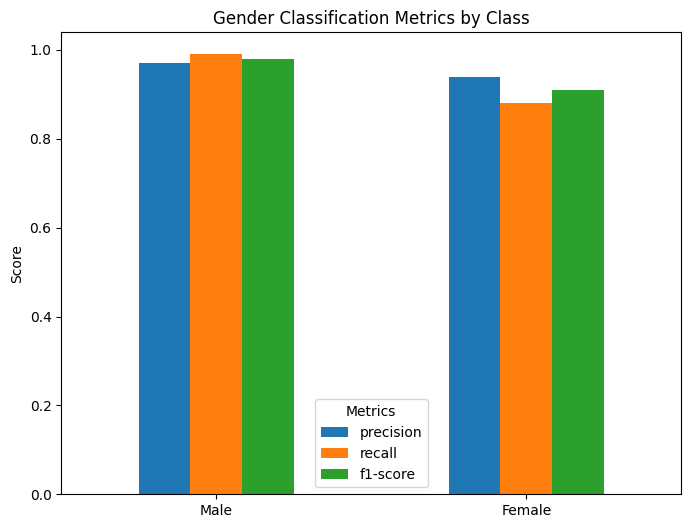

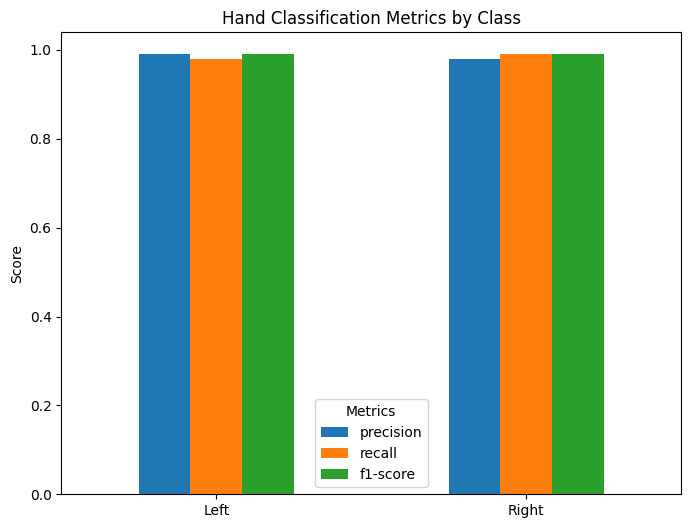

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert gender_class_metrics to DataFrame
gender_df = pd.DataFrame.from_dict(gender_class_metrics, orient='index')

# Create bar plot for gender metrics
ax1 = gender_df.plot(kind='bar', figsize=(8, 6))
ax1.set_title('Gender Classification Metrics by Class')
ax1.set_ylabel('Score')
ax1.tick_params(axis='x', rotation=0)
plt.legend(title='Metrics')
plt.show()

# Convert hand_class_metrics to DataFrame
hand_df = pd.DataFrame.from_dict(hand_class_metrics, orient='index')

# Create bar plot for hand metrics
ax2 = hand_df.plot(kind='bar', figsize=(8, 6))
ax2.set_title('Hand Classification Metrics by Class')
ax2.set_ylabel('Score')
ax2.tick_params(axis='x', rotation=0)
plt.legend(title='Metrics')
plt.show()

**Reasoning**:
Create a bar plot to visualize the precision, recall, and f1-score for each class in the finger classification report.



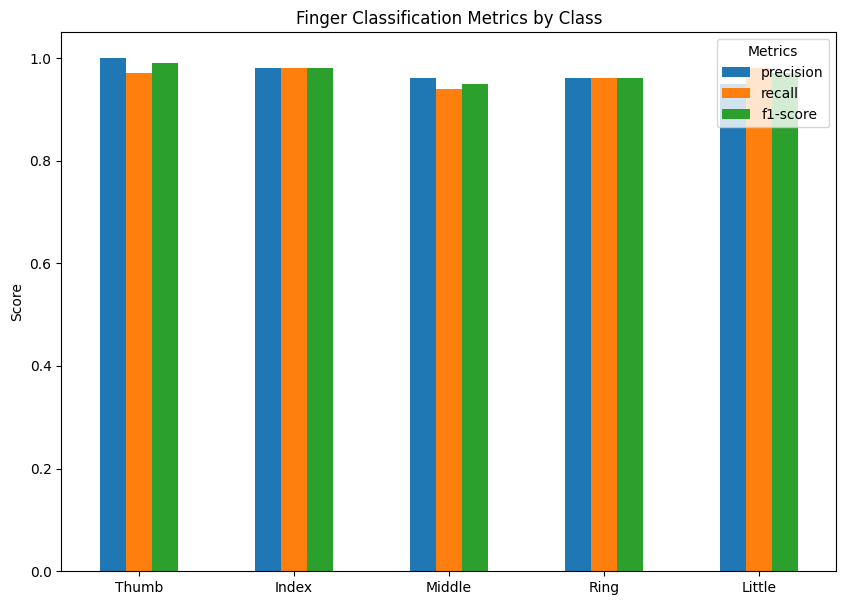

In [30]:
# Convert finger_class_metrics to DataFrame
finger_df = pd.DataFrame.from_dict(finger_class_metrics, orient='index')

# Create bar plot for finger metrics
ax3 = finger_df.plot(kind='bar', figsize=(10, 7))
ax3.set_title('Finger Classification Metrics by Class')
ax3.set_ylabel('Score')
ax3.tick_params(axis='x', rotation=0)
plt.legend(title='Metrics')
plt.show()

## Compare model performance

### Subtask:
Create plots or tables to compare the overall performance metrics (accuracy, macro avg, weighted avg) across the three models (Gender, Hand, Finger).


**Reasoning**:
Create a dictionary with overall metrics, convert it to a DataFrame, and then plot the overall accuracy for each model.



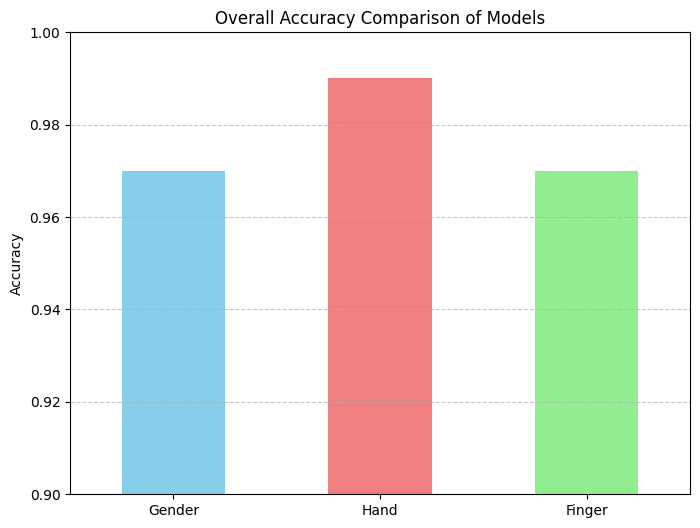

In [32]:
import matplotlib.pyplot as plt

# 1. Create a dictionary containing the overall metrics for each model
overall_metrics_dict = {
    'Gender': gender_overall_metrics,
    'Hand': hand_overall_metrics,
    'Finger': finger_overall_metrics
}

# 2. Convert this dictionary into a pandas DataFrame
overall_metrics_df = pd.DataFrame.from_dict(overall_metrics_dict, orient='index')

# 3. Create a bar plot to visualize the overall accuracy
overall_metrics_df['accuracy'].plot(kind='bar', figsize=(8, 6), color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Overall Accuracy Comparison of Models')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0) # Set y-axis limits to better visualize differences
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Reasoning**:
Visualize the macro average and weighted average precision, recall, and f1-score for the three models using grouped bar plots.



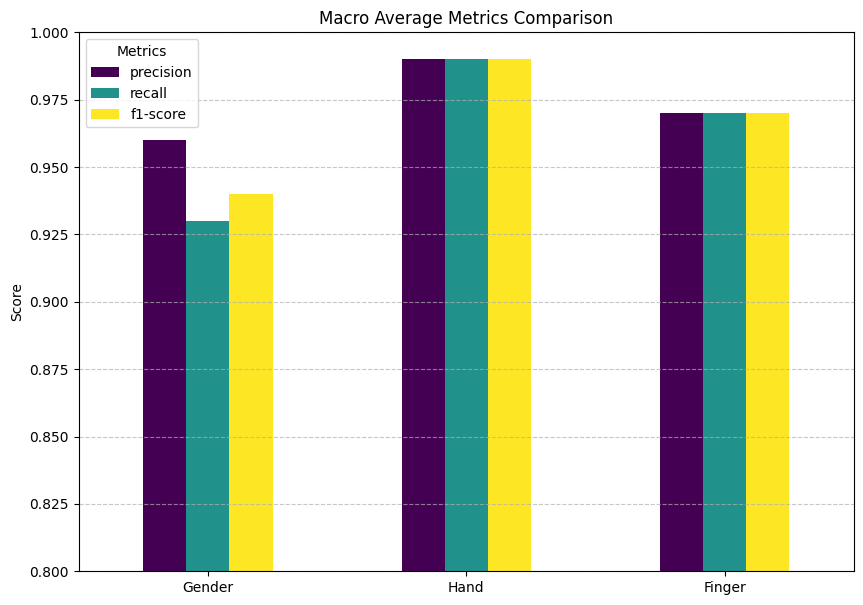

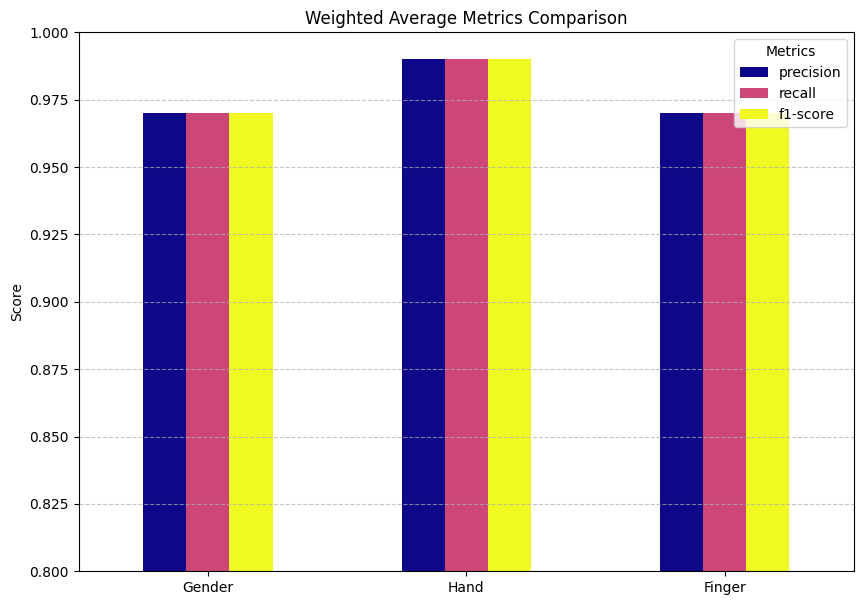

In [33]:
# 4. Create separate bar plots or grouped bar plots to visualize the macro average and weighted average metrics

# Macro average metrics
macro_avg_df = pd.DataFrame({
    'precision': overall_metrics_df['macro_avg'].apply(lambda x: x['precision']),
    'recall': overall_metrics_df['macro_avg'].apply(lambda x: x['recall']),
    'f1-score': overall_metrics_df['macro_avg'].apply(lambda x: x['f1-score'])
})

macro_avg_df.plot(kind='bar', figsize=(10, 7), colormap='viridis')
plt.title('Macro Average Metrics Comparison')
plt.ylabel('Score')
plt.ylim(0.8, 1.0)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metrics')
plt.show()

# Weighted average metrics
weighted_avg_df = pd.DataFrame({
    'precision': overall_metrics_df['weighted_avg'].apply(lambda x: x['precision']),
    'recall': overall_metrics_df['weighted_avg'].apply(lambda x: x['recall']),
    'f1-score': overall_metrics_df['weighted_avg'].apply(lambda x: x['f1-score'])
})

weighted_avg_df.plot(kind='bar', figsize=(10, 7), colormap='plasma')
plt.title('Weighted Average Metrics Comparison')
plt.ylabel('Score')
plt.ylim(0.8, 1.0)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metrics')
plt.show()

## Summary:

### Data Analysis Key Findings

*   The overall accuracy of the Gender, Hand, and Finger classification models are relatively high, all above 0.9.
*   The macro average and weighted average metrics (precision, recall, and f1-score) are also high for all three models, generally above 0.8.

### Insights or Next Steps

*   The high performance across all models suggests that the features used for classification are effective.
*   Further analysis of the class-wise metrics (as visualized in the bar plots) could reveal potential areas for improvement for specific classes within each model, although the overall performance is strong.
